# Estimating COVID-19's $R_t$ in Real-Time with PYMC3

Kevin Systrom - April 22

Model originally built by [Thomas Vladeck](https://github.com/tvladeck) in Stan, parts inspired by the work over at https://epiforecasts.io/, lots of help from [Thomas Wiecki](https://twitter.com/twiecki). Thank you to everyone who helped.

This notebook is a WIP - I'll add more context and commentary over the coming week.

In [84]:
# For some reason Theano is unhappy when I run the GP, need to disable future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import requests
import pymc3 as pm
import pandas as pd
import numpy as np
import theano
import theano.tensor as tt

from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from matplotlib import ticker

from datetime import date
from datetime import datetime

from IPython.display import clear_output

%config InlineBackend.figure_format = 'retina'

## Load State Information
#### Load

In [62]:
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv'
ita_regions = pd.read_csv(url,
                     usecols=[0,3,15],
                     index_col=['denominazione_regione', 'data'],
                     parse_dates=['data'],
                     squeeze=True).sort_index()

In [63]:
ita_regions=ita_regions.to_frame()

In [64]:
ita_regions

totale_casi
denominazione_regione data                            
Abruzzo               2020-02-24 18:00:00            0
                      2020-02-25 18:00:00            0
                      2020-02-26 18:00:00            0
                      2020-02-27 18:00:00            1
                      2020-02-28 18:00:00            1
...                                                ...
Veneto                2020-04-29 17:00:00        17825
                      2020-04-30 17:00:00        17960
                      2020-05-01 17:00:00        18098
                      2020-05-02 17:00:00        18224
                      2020-05-03 17:00:00        18318

[1470 rows x 1 columns]

In [3]:
url = 'https://covidtracking.com/api/v1/states/daily.csv'
states = pd.read_csv(url,
                     parse_dates=['date'],
                     index_col=['state', 'date']).sort_index()

# Note: GU/AS/VI do not have enough data for this model to run
# Note: PR had -384 change recently in total count so unable to model
states = states.drop(['MA','MP', 'GU', 'AS', 'PR', 'VI', 'NY', 'CA','OR','NJ','UT','NV','VA','FL','GA','ID','TX','IN','ID','IL'])

In [4]:
states

positive  negative  pending  hospitalizedCurrently  \
state date                                                             
AK    2020-03-06       0.0       8.0      1.0                    NaN   
      2020-03-07       0.0      12.0      2.0                    NaN   
      2020-03-08       0.0      14.0      6.0                    NaN   
      2020-03-09       0.0      23.0      9.0                    NaN   
      2020-03-10       0.0      23.0      9.0                    NaN   
...                    ...       ...      ...                    ...   
WY    2020-04-28     389.0    8226.0      NaN                   16.0   
      2020-04-29     536.0    8681.0      NaN                   12.0   
      2020-04-30     544.0    8902.0      NaN                   13.0   
      2020-05-01     559.0    9136.0      NaN                   13.0   
      2020-05-02     566.0    9463.0      NaN                   13.0   

                  hospitalizedCumulative  inIcuCurrently  inIcuCumulative  \
state date                                                                  
AK    2020-03-06                     NaN             NaN              NaN   
      2020-03-07                     NaN             NaN              NaN   
      2020-03-08                     NaN             NaN              NaN   
      2020-03-09                     NaN             NaN              NaN   
      2020-03-10                     NaN             NaN              NaN   
...                                  ...             ...              ...   
WY    2020-04-28                    56.0             NaN              NaN   
      2020-04-29                    56.0             NaN              NaN   
      2020-04-30                    56.0             NaN              NaN   
      2020-05-01                    56.0             NaN              NaN   
      2020-05-02                    58.0             NaN              NaN   

                  onVentilatorCurrently  onVentilatorCumulative  recovered  \
state date                                                                   
AK    2020-03-06                    NaN                     NaN        NaN   
      2020-03-07                    NaN                     NaN        NaN   
      2020-03-08                    NaN                     NaN        NaN   
      2020-03-09                    NaN                     NaN        NaN   
      2020-03-10                    NaN                     NaN        NaN   
...                                 ...                     ...        ...   
WY    2020-04-28                    NaN                     NaN      343.0   
      2020-04-29                    NaN                     NaN      362.0   
      2020-04-30                    NaN                     NaN      371.0   
      2020-05-01                    NaN                     NaN      373.0   
      2020-05-02                    NaN                     NaN      387.0   

                  ... hospitalized    total  totalTestResults   posNeg  fips  \
state date        ...                                                          
AK    2020-03-06  ...          NaN      9.0               8.0      8.0     2   
      2020-03-07  ...          NaN     14.0              12.0     12.0     2   
      2020-03-08  ...          NaN     20.0              14.0     14.0     2   
      2020-03-09  ...          NaN     32.0              23.0     23.0     2   
      2020-03-10  ...          NaN     32.0              23.0     23.0     2   
...               ...          ...      ...               ...      ...   ...   
WY    2020-04-28  ...         56.0   8615.0            8615.0   8615.0    56   
      2020-04-29  ...         56.0   9217.0            9217.0   9217.0    56   
      2020-04-30  ...         56.0   9446.0            9446.0   9446.0    56   
      2020-05-01  ...         56.0   9695.0            9695.0   9695.0    56   
      2020-05-02  ...         58.0  10029.0           10029.0  10029.0    56   

                  death

#### Clean data with known modifications

## Load Patient Information
#### Download
~100mb download (be ... patient!)

In [8]:
def download_file(url, local_filename):
    """From https://stackoverflow.com/questions/16694907/"""
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
    return local_filename


URL = "https://raw.githubusercontent.com/beoutbreakprepared/nCoV2019/master/latest_data/latestdata.csv"
LINELIST_PATH = 'data/linelist.csv'

if not os.path.exists(LINELIST_PATH):
    print('Downloading file, this will take a while ~100mb')
    try:
        download_file(URL, LINELIST_PATH)
        clear_output(wait=True)
        print('Done downloading.')
    except:
        print('Something went wrong. Try again.')
else:
    print('Already downloaded CSV')

Already downloaded CSV


#### Parse & Clean Patient Info

In [9]:
# Load the patient CSV
patients = pd.read_csv(
    'data/linelist.csv',
    parse_dates=False,
    usecols=[
        'date_confirmation',
        'date_onset_symptoms'],
    low_memory=False)

patients.columns = ['Onset', 'Confirmed']

# There's an errant reversed date
patients = patients.replace('01.31.2020', '31.01.2020')

# Only keep if both values are present
patients = patients.dropna()

# Must have strings that look like individual dates
# "2020.03.09" is 10 chars long
is_ten_char = lambda x: x.str.len().eq(10)
patients = patients[is_ten_char(patients.Confirmed) & 
                    is_ten_char(patients.Onset)]

# Convert both to datetimes
patients.Confirmed = pd.to_datetime(
    patients.Confirmed, format='%d.%m.%Y')
patients.Onset = pd.to_datetime(
    patients.Onset, format='%d.%m.%Y')

# Only keep records where confirmed > onset
patients = patients[patients.Confirmed >= patients.Onset]

#### Show Relationship between Onset of Symptoms and Confirmation

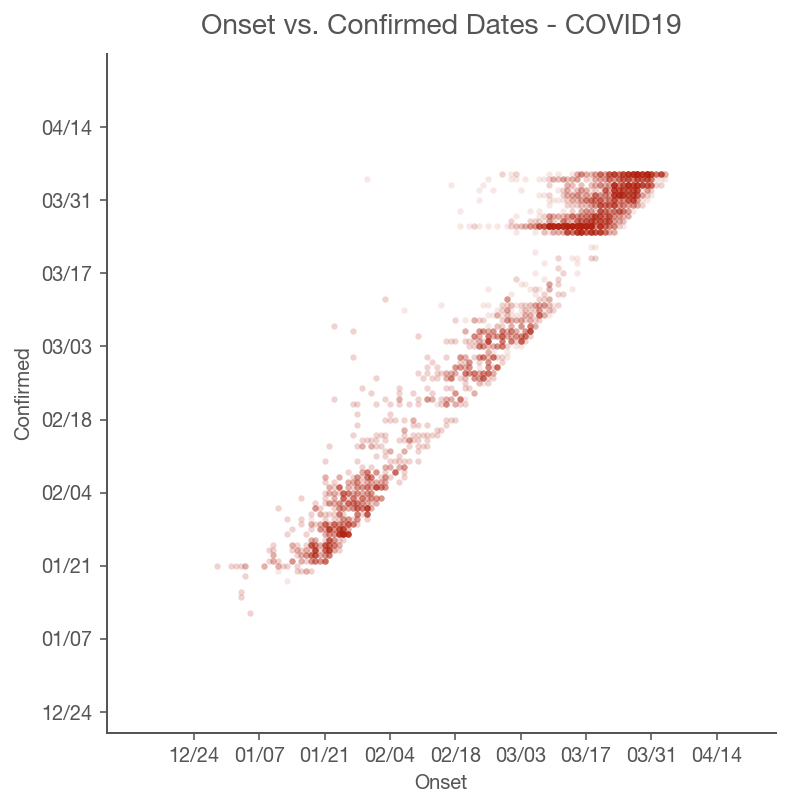

In [10]:
ax = patients.plot.scatter(
    title='Onset vs. Confirmed Dates - COVID19',
    x='Onset',
    y='Confirmed',
    alpha=.1,
    lw=0,
    s=10,
    figsize=(6,6))

formatter = mdates.DateFormatter('%m/%d')
locator = mdates.WeekdayLocator(interval=2)

for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(formatter)
    axis.set_major_locator(locator)

#### Calculate the Probability Distribution of Delay

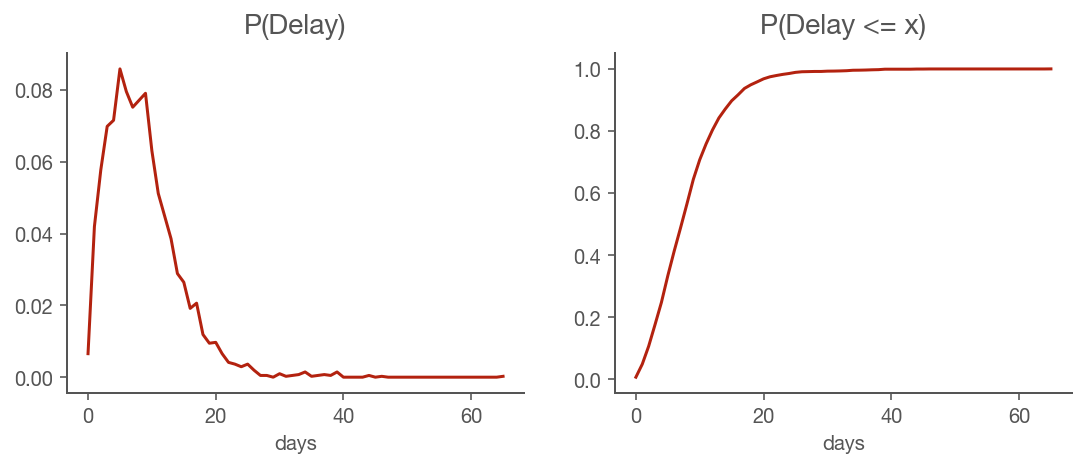

In [65]:
# Calculate the delta in days between onset and confirmation
delay = (patients.Confirmed - patients.Onset).dt.days

# Convert samples to an empirical distribution
p_delay = delay.value_counts().sort_index()
new_range = np.arange(0, p_delay.index.max()+1)
p_delay = p_delay.reindex(new_range, fill_value=0)
p_delay /= p_delay.sum()

# Show our work
fig, axes = plt.subplots(ncols=2, figsize=(9,3))
p_delay.plot(title='P(Delay)', ax=axes[0])
p_delay.cumsum().plot(title='P(Delay <= x)', ax=axes[1])
for ax in axes:
    ax.set_xlabel('days')

## A Single State

#### Select State Data

In [91]:
state = 'Basilicata'
confirmed = ita_regions.xs(state).totale_casi.diff().dropna()
confirmed.tail()

data
2020-04-29 17:00:00     0.0
2020-04-30 17:00:00     1.0
2020-05-01 17:00:00    11.0
2020-05-02 17:00:00     2.0
2020-05-03 17:00:00     6.0
Name: totale_casi, dtype: float64

### Translate Confirmation Dates to Onset Dates

Our goal is to translate positive test counts to the dates where they likely occured. Since we have the distribution, we can distribute case counts back in time according to that distribution. To accomplish this, we reverse the case time series, and convolve it using the distribution of delay from onset to confirmation. Then we reverse the series again to obtain the onset curve. Note that this means the data will be 'right censored' which means there are onset cases that have yet to be reported so it looks as if the count has gone down.

In [94]:
def confirmed_to_onset(confirmed, p_delay):

    assert not confirmed.isna().any()
    
    # Reverse cases so that we convolve into the past
    convolved = np.convolve(confirmed[::-1].values, p_delay)

    # Calculate the new date range
    dr = pd.date_range(end=confirmed.index[-1],
                       periods=len(convolved))

    # Flip the values and assign the date range
    onset = pd.Series(np.flip(convolved), index=dr)
    
    return onset


onset = confirmed_to_onset(confirmed, p_delay)

### Adjust for Right-Censoring

Since we distributed observed cases into the past to recreate the onset curve, we now have a right-censored time series. We can correct for that by asking what % of people have a delay less than or equal to the time between the day in question and the current day.

For example, 5 days ago, there might have been 100 cases onset. Over the course of the next 5 days some portion of those cases will be reported. This portion is equal to the cumulative distribution function of our delay distribution. If we know that portion is say, 60%, then our current count of onset on that day represents 60% of the total. This implies that the total is 166% higher. We apply this correction to get an idea of what actual onset cases are likely, thus removing the right censoring.

In [95]:
def adjust_onset_for_right_censorship(onset, p_delay):
    cumulative_p_delay = p_delay.cumsum()
    
    # Calculate the additional ones needed so shapes match
    ones_needed = len(onset) - len(cumulative_p_delay)
    padding_shape = (0, ones_needed)
    
    # Add ones and flip back
    cumulative_p_delay = np.pad(
        cumulative_p_delay,
        padding_shape,
        constant_values=1)
    cumulative_p_delay = np.flip(cumulative_p_delay)
    
    # Adjusts observed onset values to expected terminal onset values
    adjusted = onset / cumulative_p_delay
    
    return adjusted, cumulative_p_delay


adjusted, cumulative_p_delay = adjust_onset_for_right_censorship(onset, p_delay)

Take a look at all three series: confirmed, onset and onset adjusted for right censoring.

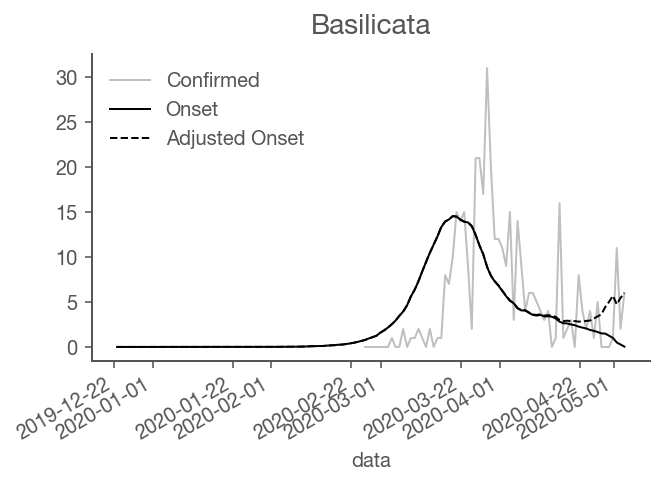

In [96]:
fig, ax = plt.subplots(figsize=(5,3))

confirmed.plot(
    ax=ax,
    label='Confirmed',
    title=state,
    c='k',
    alpha=.25,
    lw=1)

onset.plot(
    ax=ax,
    label='Onset',
    c='k',
    lw=1)

adjusted.plot(
    ax=ax,
    label='Adjusted Onset',
    c='k',
    linestyle='--',
    lw=1)

ax.legend();

Let's have the model run on days where we have enough data ~last 50 or so

### Sample the Posterior with PyMC3

We assume a poisson likelihood function and feed it what we believe is the onset curve based on reported data. We model this onset curve based on the same math in the previous notebook:

$$ I^\prime = Ie^{\gamma(R_t-1)} $$

We define $\theta = \gamma(R_t-1)$ and model $ I^\prime = Ie^{\theta} $ where $\theta$ observes a random walk. We let $\gamma$ vary independently based on known parameters for the serial interval. Therefore, we can recover $R_t$ easily by $R_t = \frac{\theta}{\gamma}+1$

The only tricky part is understanding that we're feeding in _onset_ cases to the likelihood. So $\mu$ of the poisson is the positive, non-zero, expected onset cases we think we'd see today.

We calculate this by figuring out how many cases we'd expect there to be yesterday total when adjusted for bias and plugging it into the first equation above. We then have to re-bias this number back down to get the expected amount of onset cases observed that day.

In [80]:
class MCMCModel(object):
    
    def __init__(self, region, onset, cumulative_p_delay, window=75):
        
        # Just for identification purposes
        self.region = region
        
        # For the model, we'll only look at the last N
        self.onset = onset.iloc[-window:]
        self.cumulative_p_delay = cumulative_p_delay[-window:]
        
        # Where we store the results
        self.trace = None
        self.trace_index = self.onset.index[1:]

    def run(self, chains=1, tune=3000, draws=1000, target_accept=.95):

        with pm.Model() as model:

            # Random walk magnitude
            step_size = pm.HalfNormal('step_size', sd=.03)

            # Theta random walk
            theta_raw_init = pm.Normal('theta_raw_init', 0.1, 0.1)
            theta_raw_steps = pm.Normal('theta_raw_steps', shape=len(self.onset)-2) * step_size
            theta_raw = tt.concatenate([[theta_raw_init], theta_raw_steps])
            theta = pm.Deterministic('theta', theta_raw.cumsum())

            # Let the serial interval be a random variable and calculate r_t
            serial_interval = pm.Gamma('serial_interval', alpha=6, beta=1.5)
            gamma = 1.0 / serial_interval
            r_t = pm.Deterministic('r_t', theta/gamma + 1)

            inferred_yesterday = self.onset.values[:-1] / self.cumulative_p_delay[:-1]
            
            expected_today = inferred_yesterday * self.cumulative_p_delay[1:] * pm.math.exp(theta)

            # Ensure cases stay above zero for poisson
            mu = pm.math.maximum(.1, expected_today)
            observed = self.onset.round().values[1:]
            cases = pm.Poisson('cases', mu=mu, observed=observed)

            self.trace = pm.sample(
                chains=chains,
                tune=tune,
                draws=draws,
                target_accept=target_accept)
            
            return self
    
    def run_gp(self):
        with pm.Model() as model:
            gp_shape = len(self.onset) - 1

            length_scale = pm.Gamma("length_scale", alpha=3, beta=.4)

            eta = .05
            cov_func = eta**2 * pm.gp.cov.ExpQuad(1, length_scale)

            gp = pm.gp.Latent(mean_func=pm.gp.mean.Constant(c=0), 
                              cov_func=cov_func)

            # Place a GP prior over the function f.
            theta = gp.prior("theta", X=np.arange(gp_shape)[:, None])

            # Let the serial interval be a random variable and calculate r_t
            serial_interval = pm.Gamma('serial_interval', alpha=6, beta=1.5)
            gamma = 1.0 / serial_interval
            r_t = pm.Deterministic('r_t', theta / gamma + 1)

            inferred_yesterday = self.onset.values[:-1] / self.cumulative_p_delay[:-1]
            expected_today = inferred_yesterday * self.cumulative_p_delay[1:] * pm.math.exp(theta)

            # Ensure cases stay above zero for poisson
            mu = pm.math.maximum(.1, expected_today)
            observed = self.onset.round().values[1:]
            cases = pm.Poisson('cases', mu=mu, observed=observed)

            self.trace = pm.sample(chains=1, tune=1000, draws=1000, target_accept=.8)
        return self

### Run Pymc3 Model

In [81]:
def df_from_model(model):
    
    r_t = model.trace['r_t']
    mean = np.mean(r_t, axis=0)
    median = np.median(r_t, axis=0)
    hpd_90 = pm.stats.hpd(r_t, alpha=.1)
    hpd_50 = pm.stats.hpd(r_t, alpha=.5)
    
    idx = pd.MultiIndex.from_product([
            [model.region],
            model.trace_index
        ], names=['denominazione_regione', 'data'])
        
    df = pd.DataFrame(data=np.c_[mean, median, hpd_90, hpd_50], index=idx,
                 columns=['mean', 'median', 'lower_90', 'upper_90', 'lower_50','upper_50'])
    return df

def create_and_run_model(name, state):
    confirmed = state.totale_casi.diff().dropna()
    onset = confirmed_to_onset(confirmed, p_delay)
    adjusted, cumulative_p_delay = adjust_onset_for_right_censorship(onset, p_delay)
    return MCMCModel(name, onset, cumulative_p_delay).run()

In [82]:
models = {}

for state, grp in ita_regions.groupby('denominazione_regione'):
    
    print(state)
    
    if state in models:
        print(f'Skipping {state}, already in cache')
        continue
    name=state
    models[state] = create_and_run_model(name, grp.droplevel(0))

Abruzzo


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
100%|██████████| 4000/4000 [00:16<00:00, 243.52it/s]
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6710002141554817, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


Basilicata


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
100%|██████████| 4000/4000 [00:09<00:00, 410.15it/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


Calabria


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
100%|██████████| 4000/4000 [00:11<00:00, 343.90it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8790404165345767, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


Campania


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
100%|██████████| 4000/4000 [00:17<00:00, 227.58it/s]
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


Emilia-Romagna


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
100%|██████████| 4000/4000 [00:20<00:00, 194.72it/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


Friuli Venezia Giulia


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
100%|██████████| 4000/4000 [00:15<00:00, 264.58it/s]
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


Lazio


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
100%|██████████| 4000/4000 [00:17<00:00, 228.18it/s]
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


Liguria


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
100%|██████████| 4000/4000 [00:17<00:00, 223.00it/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


Lombardia


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
100%|██████████| 4000/4000 [00:31<00:00, 126.79it/s]
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


Marche


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
100%|██████████| 4000/4000 [00:17<00:00, 233.76it/s]
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


Molise


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
100%|██████████| 4000/4000 [00:09<00:00, 419.56it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


P.A. Bolzano


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
100%|██████████| 4000/4000 [00:14<00:00, 275.64it/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


P.A. Trento


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
100%|██████████| 4000/4000 [00:16<00:00, 244.02it/s]
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6658435391505826, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


Piemonte


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
100%|██████████| 4000/4000 [04:35<00:00, 14.54it/s] 
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


Puglia


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
100%|██████████| 4000/4000 [00:17<00:00, 224.89it/s]
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


Sardegna


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
100%|██████████| 4000/4000 [00:13<00:00, 288.32it/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


Sicilia


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
100%|██████████| 4000/4000 [00:17<00:00, 228.30it/s]
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


Toscana


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
100%|██████████| 4000/4000 [00:19<00:00, 209.59it/s]
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


Umbria


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
100%|██████████| 4000/4000 [00:13<00:00, 298.95it/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


Valle d'Aosta


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
100%|██████████| 4000/4000 [00:12<00:00, 326.86it/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


Veneto


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
100%|██████████| 4000/4000 [00:18<00:00, 211.12it/s]
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


### Handle Divergences

In [ ]:
# Check to see if there were divergences
n_diverging = lambda x: x.trace['diverging'].nonzero()[0].size
divergences = pd.Series([n_diverging(m) for m in models.values()], index=models.keys())
has_divergences = divergences.gt(0)

print('Diverging states:')
display(divergences[has_divergences])

# Rerun states with divergences
for state, n_divergences in divergences[has_divergences].items():
    models[state].run()

Diverging states:


Abruzzo                   9
Basilicata                3
Calabria                  1
Campania                 11
Emilia-Romagna            4
Friuli Venezia Giulia     6
Lazio                    14
Liguria                   5
Lombardia                10
Marche                   14
P.A. Bolzano              3
P.A. Trento               8
Piemonte                 15
Puglia                    9
Sardegna                  3
Sicilia                   8
Toscana                  12
Umbria                    2
Valle d'Aosta             2
Veneto                   28
dtype: int64

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
100%|██████████| 4000/4000 [00:16<00:00, 248.71it/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
100%|██████████| 4000/4000 [00:09<00:00, 413.89it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
100%|█████

## Compile Results

In [85]:
results = None

for state, model in models.items():

    df = df_from_model(model)

    if results is None:
        results = df
    else:
        results = pd.concat([results, df], axis=0)

In [86]:
results.loc['Veneto']

,mean,median,lower_90,upper_90,lower_50,upper_50
data,,,,,,
2020-02-20 17:00:00,1.484817,1.430283,1.087625,1.913553,1.136707,1.463973
2020-02-21 17:00:00,1.491017,1.432714,1.101644,1.933210,1.186204,1.509030
2020-02-22 17:00:00,1.484998,1.430695,1.092200,1.865046,1.154566,1.468258
2020-02-23 17:00:00,1.477340,1.428144,1.096037,1.850752,1.181557,1.479916
2020-02-24 17:00:00,1.466455,1.423268,1.125305,1.824487,1.184847,1.476479
...,...,...,...,...,...,...
2020-04-29 17:00:00,0.816991,0.834449,0.542390,1.077604,0.765466,0.954972
2020-04-30 17:00:00,0.819282,0.846612,0.511266,1.070404,0.767901,0.961197
2020-05-01 17:00:00,0.811194,0.843176,0.533398,1.136121,0.772672,0.988173


### Render to CSV
Uncomment if you'd like

In [632]:
#results.to_csv('data/rt_2020_04_23.csv')

### Render Charts

In [87]:
def plot_rt(name, result, ax, c=(.3,.3,.3,1), ci=(0,0,0,.05)):
    ax.set_ylim(0.5, 1.6)
    ax.set_title(name)
    ax.plot(result['median'],
            marker='o',
            markersize=4,
            markerfacecolor='w',
            lw=1,
            c=c,
            markevery=2)
    ax.fill_between(
        result.index,
        result['lower_50'].values,
        result['upper_50'].values,
        color=ci,
        lw=0)
    ax.axhline(1.0, linestyle=':', lw=1)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))

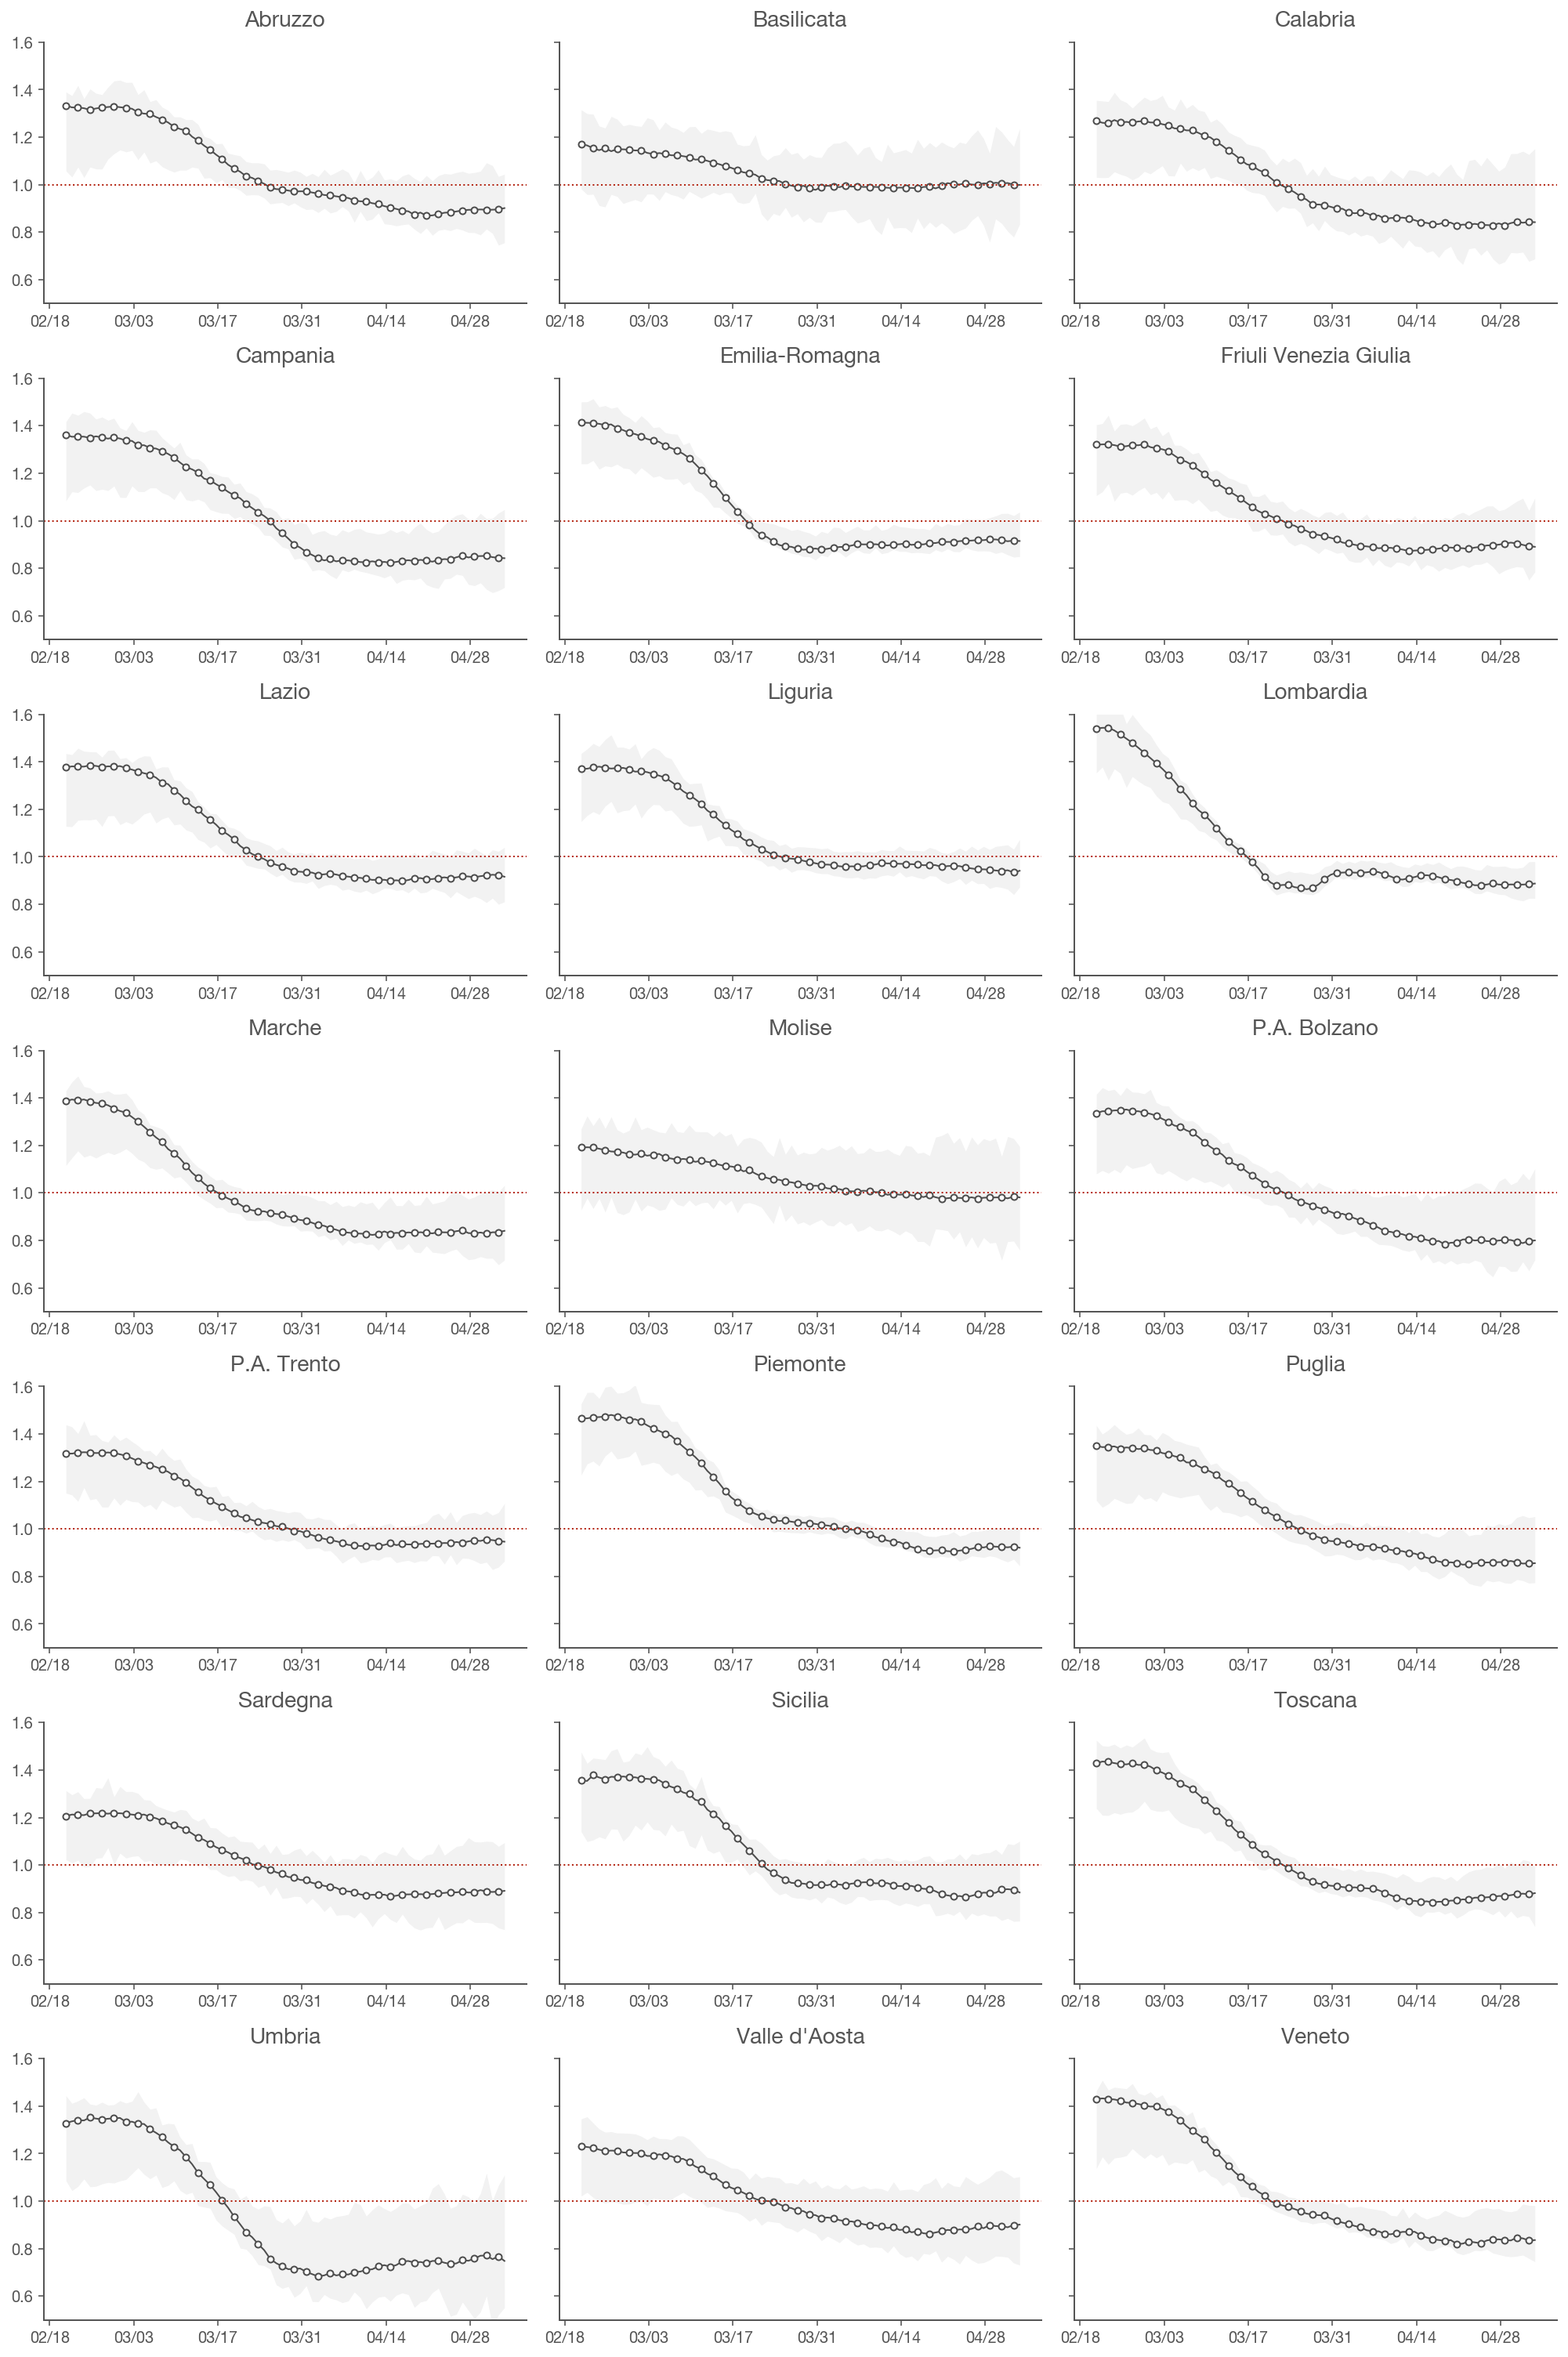

In [88]:
ncols = 3
nrows = int(np.ceil(results.index.levels[0].shape[0] / ncols))

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(14, nrows*3),
    sharey='row')

for ax, (state, result) in zip(axes.flat, results.groupby('denominazione_regione')):
    plot_rt(state, result.droplevel(0), ax)

fig.tight_layout()
fig.set_facecolor('w')
plt.savefig('/Users/Michele/Desktop/Regioni_Rt.png')

In [439]:
# url = 'https://raw.githubusercontent.com/jasonong/List-of-US-States/master/states.csv'
# abbrev = pd.read_csv(url, index_col=['State'], squeeze=True)

# jhu_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
# jhu = pd.read_csv(jhu_url)

# jhu = jhu.drop(columns=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Country_Region', 'Lat', 'Long_', 'Combined_Key'])
# jhu = jhu.set_index('Province_State')
# jhu.index = jhu.index.rename('region')
# jhu = jhu.drop([
#     'American Samoa',
#     'Guam',
#     'Northern Mariana Islands',
#     'Puerto Rico',
#     'Virgin Islands',
#     'Diamond Princess',
#     'Grand Princess'])

# jhu.index = pd.Index(jhu.index.to_series().replace(abbrev).values, name='region')
# jhu.columns = pd.to_datetime(jhu.columns)
# jhu = jhu.groupby('region').sum()
# jhu = jhu.stack().sort_index()

# state = 'VT'
# ax = jhu.xs(state).diff().plot(label='JHU', color='k', legend=True, title=state)
# # jhu.xs('AK').diff().rolling(7).mean().plot(ax=ax)
# states.xs(state).positive.diff().plot(ax=ax, figsize=(6,4), linestyle=':', label='Covidtracking', legend=True)
# ax.set_xlim(pd.Timestamp('2020-03-01'),None)

In [546]:
# url = 'https://raw.githubusercontent.com/epiforecasts/covid-regional/3ad63ea1acceb797f0628a8037fc206342d267e7/united-states/regional-summary/rt.csv'

# epf = pd.read_csv(url, parse_dates=['date'])
# epf.region = epf.region.replace(abbrev)
# epf = epf.set_index(['region', 'date']).sort_index()
# epf = epf.drop(['Guam', 'Puerto Rico'])

# epf_lookup = {}
# for idx, grp in epf.groupby('region'):

#     epf_lookup[idx]=grp
#     epf_grp = epf_lookup[state]
    
#     plot_rt(state, result.droplevel(0), ax)
#     plot_rt(state, epf_grp.droplevel(0), ax, c=(1,0,0,1))

In [47]:
import seaborn as sns

In [97]:
today=str(pd.to_datetime('today').date())

In [49]:
ERROR_BAR_COLOR = [.3,.3,.3]

(<Figure size 1080x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1d2ed438>)

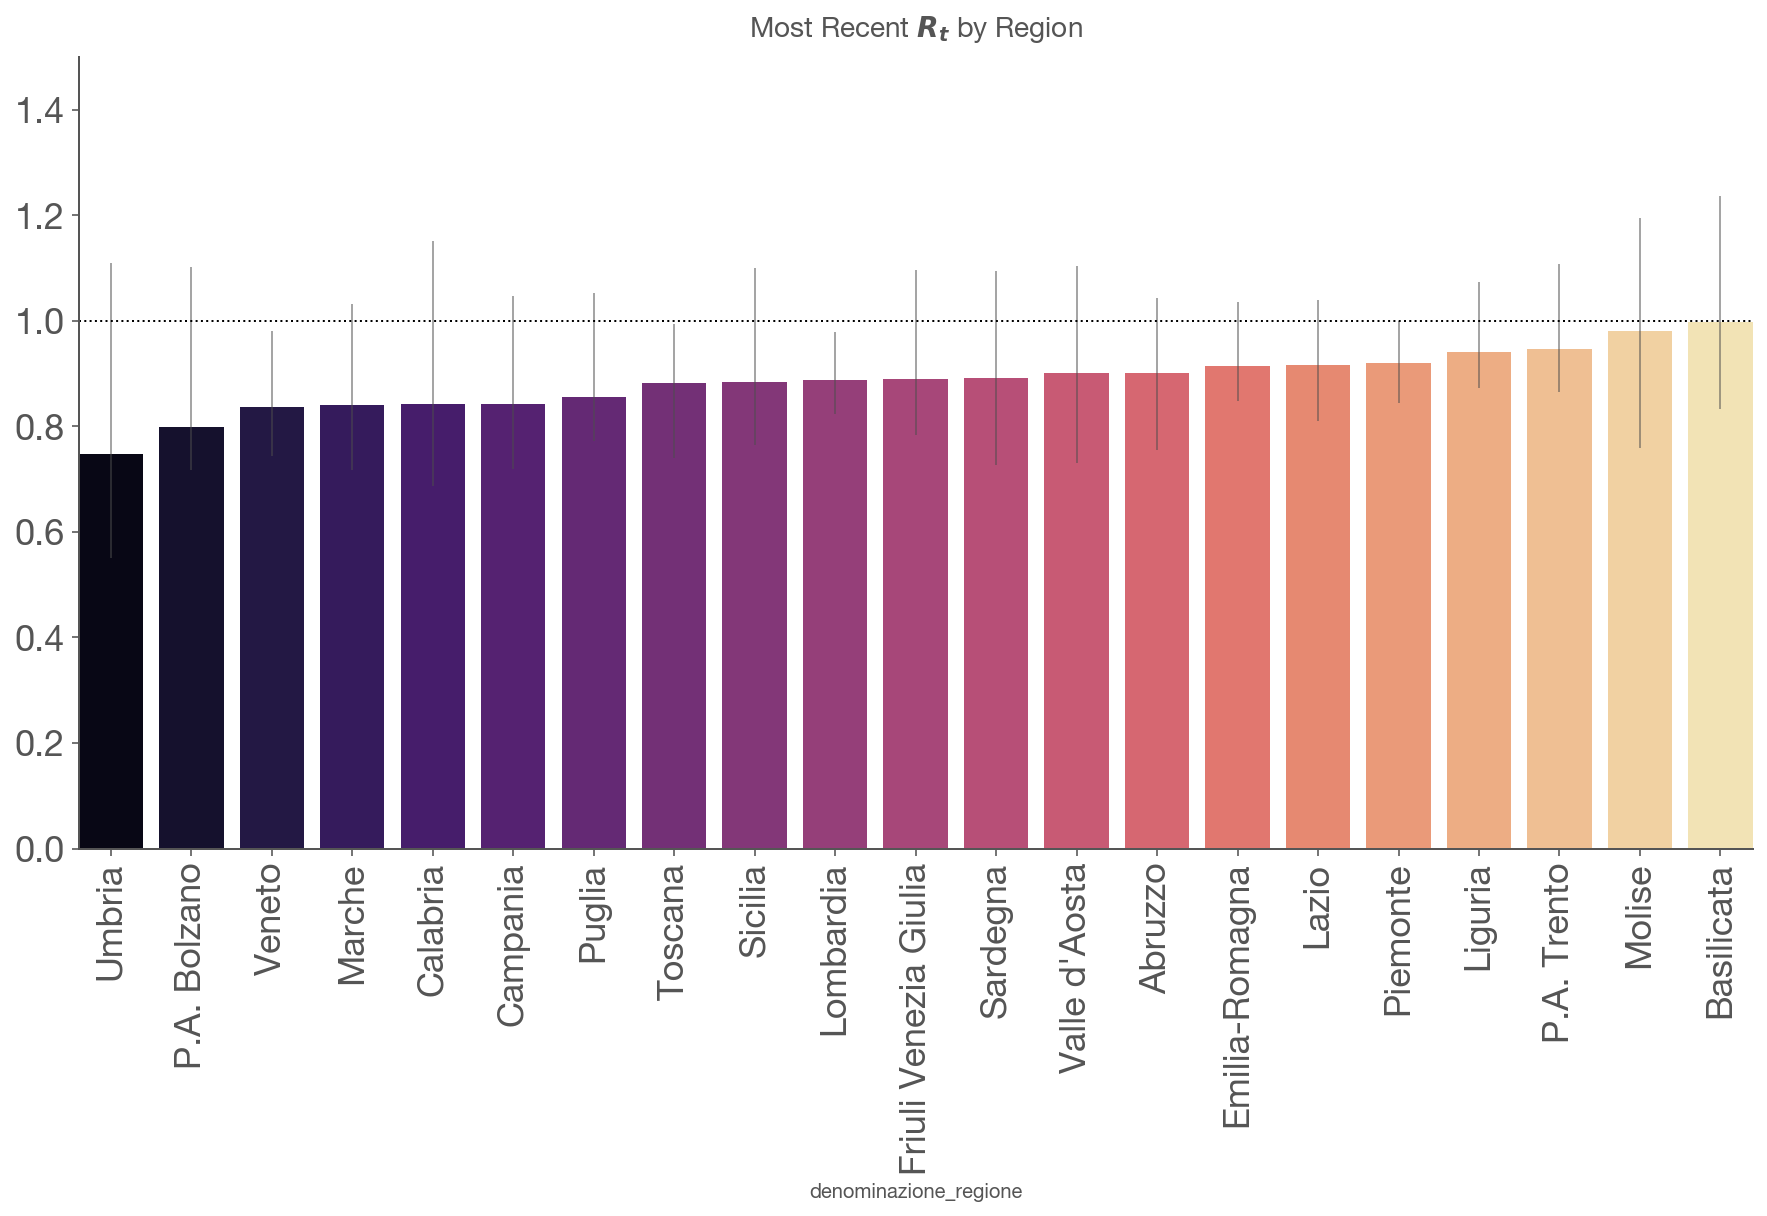

In [98]:
def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by Region', fontsize=14):
    #if not figsize:
    #    figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=(15,7))

    ax.set_title(title)
    err = mr[['lower_50', 'upper_50']].sub(mr['median'], axis=0).abs()
    bars = sns.barplot(mr.index,
                  mr['median'],
                  #width=.825,
                  #color=mr.ML.values,
                  ecolor=ERROR_BAR_COLOR,
                  palette='magma',
    
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)

    #for bar, state_name in zip(bars, mr.index):
    #    if state_name in no_lockdown:
    #        bar.set_color(NONE_COLOR)
    #    if state_name in partial_lockdown:
    #        bar.set_color(PARTIAL_COLOR)

    labels = mr.index.to_series()
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,1.5)
    plt.yticks(fontsize=18)
    plt.ylabel("")
    ax.axhline(1.0, linestyle=':', color='k', lw=1)
    ax.set_xticklabels(labels, fontsize=18)


    #leg = ax.legend(handles=[
    #                    Patch(label='Full', color=FULL_COLOR),
    #                    Patch(label='Partial', color=PARTIAL_COLOR),
    #                    Patch(label='None', color=NONE_COLOR)
    #                ],
    #                title='Lockdown',
    #                ncol=3,
    #                loc='upper left',
    #                columnspacing=.75,
    #                handletextpad=.5,
    #                handlelength=1)

    #leg._legend_box.align = "left"
    #fig.set_facecolor('w')
    plt.savefig('/Users/Michele/Desktop/Rt_Italian_regions_standings_'+today+'.png', bbox_inches='tight')
    return fig, ax

filtered=[]
mr = results.groupby(level=0)[['median', 'upper_50', 'lower_50']].last()

mr.sort_values('median', inplace=True)
plot_standings(mr)


In [90]:
mr

,median,upper_50,lower_50
denominazione_regione,,,
Umbria,0.748186,1.110497,0.550507
P.A. Bolzano,0.799711,1.101516,0.717709
Veneto,0.836017,0.981750,0.744518
Marche,0.840185,1.031487,0.716688
Calabria,0.841761,1.151373,0.686819
Campania,0.842038,1.046887,0.718492
Puglia,0.855778,1.052226,0.773113
Toscana,0.881688,0.993939,0.739946
Sicilia,0.884554,1.100318,0.764107
